In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

In [12]:
parent_dir = "./data/"

application = pd.read_csv(parent_dir + 'application_train.csv')
bureau = pd.read_csv(parent_dir + 'bureau.csv')
credit_card_balance = pd.read_csv(parent_dir + 'credit_card_balance.csv')

/var/folders/sv/tvszn8qx11ngcrsl6yd8t3c80000gp/T/ipykernel_36003/3992061473.py:3: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  application = pd.read_csv(parent_dir + 'application_train.csv')


In [13]:
print("Application Train Summary:\n", application.info())
print("Bureau Summary:\n", bureau.info())
print("Credit Card Balance Summary:\n", credit_card_balance.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(64), int64(41), object(17)
memory usage: 286.2+ MB
Application Train Summary:
 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_

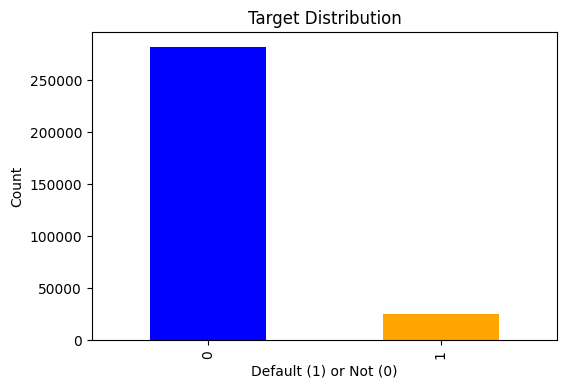

In [14]:
target_dist = application['TARGET'].value_counts()
plt.figure(figsize=(6, 4))
target_dist.plot(kind='bar', color=['blue', 'orange'])
plt.title('Target Distribution')
plt.xlabel('Default (1) or Not (0)')
plt.ylabel('Count')
plt.show()

In [15]:
missing_values = application.isnull().sum().sort_values(ascending=False)
print("Missing Values in Application:\n", missing_values[missing_values > 0])

Missing Values in Application:
 COMMONAREA_AVG              214865
COMMONAREA_MODE             214865
COMMONAREA_MEDI             214865
NONLIVINGAPARTMENTS_MEDI    213514
NONLIVINGAPARTMENTS_MODE    213514
                             ...  
EXT_SOURCE_2                   660
AMT_GOODS_PRICE                278
AMT_ANNUITY                     12
CNT_FAM_MEMBERS                  2
DAYS_LAST_PHONE_CHANGE           1
Length: 67, dtype: int64


In [16]:
numeric_columns = application.select_dtypes(include=['float64', 'int64'])
correlations = numeric_columns.corr()['TARGET'].sort_values()
print("Correlation with TARGET:\n", correlations.tail(10))

Correlation with TARGET:
 FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64


In [17]:
threshold = 0.5
missing_ratio = application.isnull().sum() / len(application)
columns_to_drop = missing_ratio[missing_ratio > threshold].index
application = application.drop(columns=columns_to_drop, axis=1)

In [18]:
numeric_data = application.select_dtypes(include=['float64', 'int64'])
non_numeric_data = application.select_dtypes(exclude=['float64', 'int64'])

In [ ]:
imputer_numeric = SimpleImputer(strategy='median')
numeric_data_imputed = pd.DataFrame(imputer_numeric.fit_transform(numeric_data), columns=numeric_data.columns)

imputer_non_numeric = SimpleImputer(strategy='most_frequent')
non_numeric_data_imputed = pd.DataFrame(imputer_non_numeric.fit_transform(non_numeric_data), columns=non_numeric_data.columns)

application_imputed = pd.concat([numeric_data_imputed, non_numeric_data_imputed], axis=1)


categorical_columns = application_imputed.select_dtypes(include=['object']).columns
application_imputed = pd.get_dummies(application_imputed, columns=categorical_columns, drop_first=True)

after_merge_imputer = SimpleImputer(strategy='median')
application_final = pd.DataFrame(
    after_merge_imputer.fit_transform(application_imputed),
    columns=application_imputed.columns
)

X = application_final.drop(columns=['TARGET', 'SK_ID_CURR'])
y = application_final['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# стандартизирует диапазон входных данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train_scaled, y_train)

RandomForestClassifier
RandomForestClassifier(random_state=42)
# Dự đoán và đánh giá
predictions = model.predict_proba(X_test_scaled)[:, 1]
auc = roc_auc_score(y_test, predictions)
print("AUC Score:", auc)



AUC Score: 0.7115971046985723


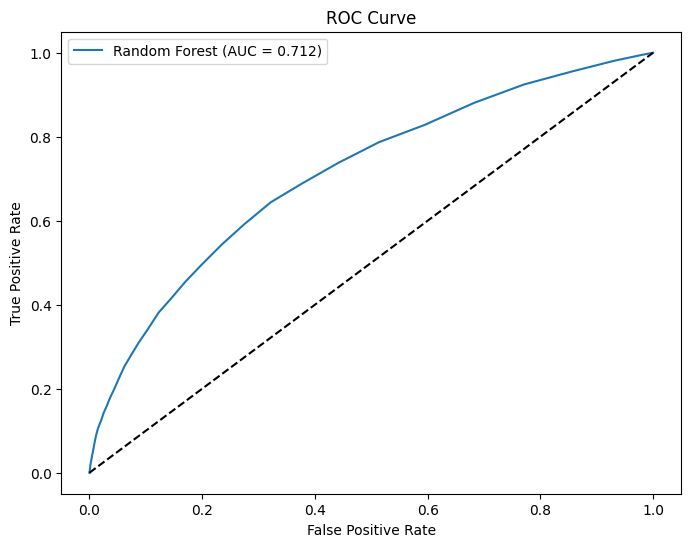

In [20]:
fpr, tpr, _ = roc_curve(y_test, predictions)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()